In [63]:
import geopandas as gpd
import pandas as pd
import numpy as np
import sklearn.cluster as cluster
from matplotlib.pylab import plt
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import zipfile
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
features = pd.read_csv('../data_processed/acs_merged_features')
complaints = pd.read_csv('../data_processed/DOB_count_illegal_conv_2015_ZC')

In [3]:
features.head()

,Unnamed: 0,Zip Code,Unemployment Rate for Pop > 16 Years (%),Percentage of Pop > 5 Years Who Don't Speak English at Home and Speak English < 'Very Well',2015 Median Household Income,Count of Illegal Resident Conversion Violations
0,0,6390.0,9.8,0.0,151083,NaN
1,1,10001.0,8.4,11.0,86801,0.0
2,2,10002.0,8.9,37.4,33726,2.0
3,3,10003.0,6.1,4.9,98151,3.0
4,4,10004.0,6.1,2.6,119691,0.0


In [4]:
complaints.head()

,Unnamed: 0,Incident Zip,Count of Complaints
0,92,11208,642
1,156,11419,617
2,157,11420,438
3,125,11355,355
4,104,11220,331


In [5]:
features = features.drop('Unnamed: 0', axis=1)
complaints = complaints.drop('Unnamed: 0', axis=1)

In [6]:
features = pd.merge(features, complaints, how='right', left_on='Zip Code', right_on='Incident Zip')

In [7]:
features.head()

,Zip Code,Unemployment Rate for Pop > 16 Years (%),Percentage of Pop > 5 Years Who Don't Speak English at Home and Speak English < 'Very Well',2015 Median Household Income,Count of Illegal Resident Conversion Violations,Incident Zip,Count of Complaints
0,10001.0,8.4,11.0,86801,0.0,10001,38
1,10002.0,8.9,37.4,33726,2.0,10002,73
2,10003.0,6.1,4.9,98151,3.0,10003,56
3,10004.0,6.1,2.6,119691,0.0,10004,1
4,10005.0,3.7,3.6,124194,0.0,10005,4


In [8]:
features.isnull().sum()

Zip Code                                                                                       1
Unemployment Rate for Pop > 16 Years (%)                                                       1
Percentage of Pop > 5 Years Who Don't Speak English at Home and Speak English < 'Very Well'    1
2015 Median Household Income                                                                   1
Count of Illegal Resident Conversion Violations                                                1
Incident Zip                                                                                   0
Count of Complaints                                                                            0
dtype: int64

In [9]:
features = features.rename(columns={'Count of Complaints':'complaints', 'Unemployment Rate for Pop > 16 Years (%)':'unemployment',"Percentage of Pop > 5 Years Who Don't Speak English at Home and Speak English < 'Very Well'":'poor_english','2015 Median Household Income':'household_income', 'Count of Illegal Resident Conversion Violations':'violations', 'Count of Complaints':'complaints'})

In [10]:
features = features.drop('Zip Code', axis=1)

In [11]:
features = features.set_index('Incident Zip')

In [12]:
print(len(features))

176


In [13]:
features.head(10)

,unemployment,poor_english,household_income,violations,complaints
Incident Zip,,,,,
10001,8.4,11.0,86801,0.0,38
10002,8.9,37.4,33726,2.0,73
10003,6.1,4.9,98151,3.0,56
10004,6.1,2.6,119691,0.0,1
10005,3.7,3.6,124194,0.0,4
10006,2.7,3.5,123691,0.0,2
10007,1.5,6.7,"250,000+",0.0,2
10009,5.6,16.8,59090,0.0,45
10010,5.8,6.1,101718,0.0,17


In [14]:
features = features.apply(pd.to_numeric, errors='coerce')

In [15]:
features.head(10)

,unemployment,poor_english,household_income,violations,complaints
Incident Zip,,,,,
10001,8.4,11.0,86801.0,0.0,38
10002,8.9,37.4,33726.0,2.0,73
10003,6.1,4.9,98151.0,3.0,56
10004,6.1,2.6,119691.0,0.0,1
10005,3.7,3.6,124194.0,0.0,4
10006,2.7,3.5,123691.0,0.0,2
10007,1.5,6.7,NaN,0.0,2
10009,5.6,16.8,59090.0,0.0,45
10010,5.8,6.1,101718.0,0.0,17


In [16]:
#features = features.drop(10007, axis=0)

In [17]:
#standardize features in preparation for cluster analysis
features = features.T
features_stand = (features - features.mean()) / features.std()
features_stand = features_stand.T
features_stand.head(10)

,unemployment,poor_english,household_income,violations,complaints
Incident Zip,,,,,
10001,-0.447367,-0.447300,1.788854,-0.447583,-0.446604
10002,-0.448635,-0.446743,1.788851,-0.449092,-0.444381
10003,-0.447473,-0.447501,1.788854,-0.447544,-0.446336
10004,-0.447145,-0.447210,1.788854,-0.447259,-0.447240
10005,-0.447198,-0.447200,1.788854,-0.447264,-0.447192
10006,-0.447202,-0.447187,1.788854,-0.447251,-0.447214
10007,-0.362789,1.433879,NaN,-0.881058,-0.190032
10009,-0.447639,-0.447215,1.788854,-0.447851,-0.446148
10010,-0.447245,-0.447238,1.788854,-0.447372,-0.446999


In [18]:
features_stand.isnull().sum()

unemployment        1
poor_english        1
household_income    3
violations          1
complaints          1
dtype: int64

In [19]:
features_stand = features_stand.dropna()

In [20]:
# determine number of clusters with sillhouette score
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(features_stand)
    silhouette_avg = silhouette_score(features_stand, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.673869957328
For n_clusters =3, the average silhouette_score is :0.596578174744
For n_clusters =4, the average silhouette_score is :0.600342353521
For n_clusters =5, the average silhouette_score is :0.535057270634
For n_clusters =6, the average silhouette_score is :0.463009000459
For n_clusters =7, the average silhouette_score is :0.455271228758


In [24]:
n = 4
km = cluster.KMeans(n_clusters=n, random_state=324)# cluster=5
km.fit(features_stand)
features_stand_KM = km.predict(features_stand)
centers = km.cluster_centers_
labels = km.labels_

In [26]:
features_stand['cluster_label'] = labels

In [27]:
features_stand.head(10)

,unemployment,poor_english,household_income,violations,complaints,cluster_label
Incident Zip,,,,,,
10001,-0.447367,-0.447300,1.788854,-0.447583,-0.446604,1
10002,-0.448635,-0.446743,1.788851,-0.449092,-0.444381,1
10003,-0.447473,-0.447501,1.788854,-0.447544,-0.446336,1
10004,-0.447145,-0.447210,1.788854,-0.447259,-0.447240,1
10005,-0.447198,-0.447200,1.788854,-0.447264,-0.447192,1
10006,-0.447202,-0.447187,1.788854,-0.447251,-0.447214,1
10009,-0.447639,-0.447215,1.788854,-0.447851,-0.446148,1
10010,-0.447245,-0.447238,1.788854,-0.447372,-0.446999,1
10011,-0.447363,-0.447318,1.788854,-0.447443,-0.446730,1


In [34]:
z = zipfile.ZipFile("../data_initial/ZIP_CODE_040114.zip")
z.extractall("../data_initial/")
zips = gpd.read_file('../data_initial/ZIP_CODE_040114.shx')

In [37]:
zips = zips.iloc[:,(11,12)]

In [40]:
zips['ZIPCODE'] = zips['ZIPCODE'].astype(float)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [42]:
features_stand = features_stand.reset_index()

In [43]:
zips.dtypes

ZIPCODE     float64
geometry     object
dtype: object

In [44]:
geodf = pd.merge(zips, features_stand, left_on='ZIPCODE', right_on='Incident Zip', how='right')

In [45]:
geodf.head()

,ZIPCODE,geometry,Incident Zip,unemployment,poor_english,household_income,violations,complaints,cluster_label
0,11436.0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,-0.448014,-0.448179,1.788852,-0.448235,-0.444424,1
1,11213.0,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,-0.448850,-0.448695,1.788847,-0.449069,-0.442232,0
2,11212.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,-0.450469,-0.450945,1.788817,-0.451446,-0.435957,3
3,11225.0,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,-0.447886,-0.448105,1.788852,-0.448573,-0.444288,1
4,11218.0,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,-0.448691,-0.447802,1.788850,-0.448771,-0.443587,0


In [53]:
type(geodf)

geopandas.geodataframe.GeoDataFrame

In [51]:
geodf.crs = {'init' :'epsg:4326'}
geodf = geodf.set_geometry('geometry')

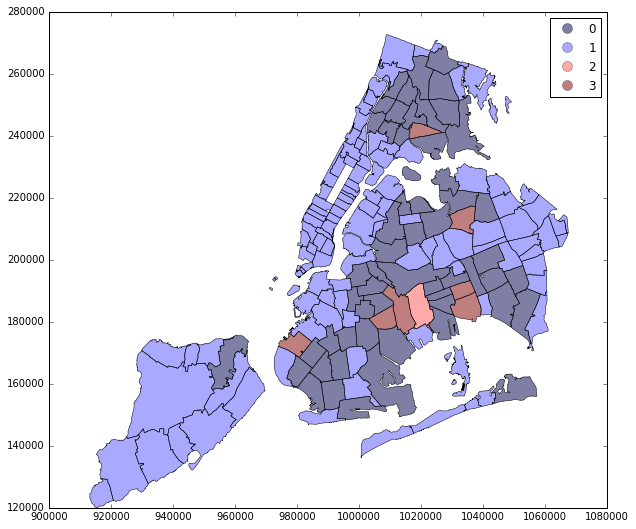

In [86]:
geodf.plot(column='cluster_label', colormap='seismic', categorical=True, linewidth=.5, figsize=(10,10), legend=True)